## Setup

In [1]:
%matplotlib widget

from pyCascade import probePost, physics
from matplotlib import pyplot as plt
import numpy as np

run = 1
category =  "single_family"


In [2]:
# ############ CLUSTER ################
# scratch_dir = '/scratch/users/nbachand/Cascade/city_block_cfd'
# home_dir = '/home/users/nbachand/Cascade/city_block_cfd'

########### LOCAL ###################
home_dir = '/home/nbachand/Documents/Cascade/city_block'
scratch_dir = home_dir

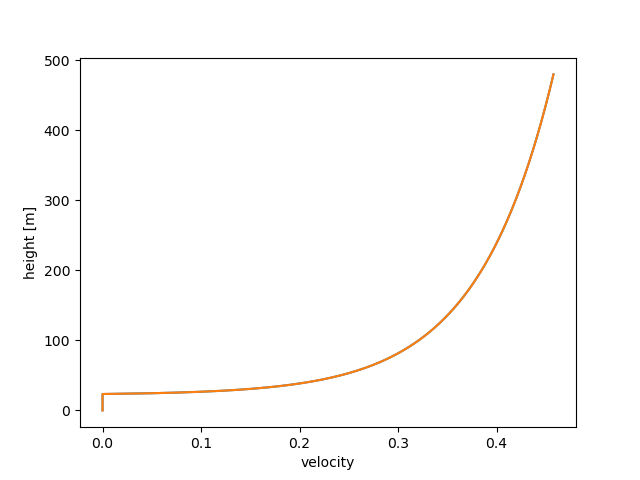

In [3]:
rho = 1.225
mu = 1.7894e-5
Re_tau = 43300
Lz =  480
hm = 20
fric_vel = Re_tau*mu/(hm*rho)

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = fric_vel*np.sqrt(1-disp/Lz)
vK_const = 0.4

LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'vK_const': vK_const,
    'Dt': 10,
    'z_values' : np.linspace(0,Lz,Lz*10)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

plt.plot(ux, LES_params['z_values'])

In [ ]:
#some info
print(f"at top of domain, u_x is {physics_setup.LES_params['log_wind'][-1]}")

In [4]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 0.45768224669677254 with L = 480.0
flat plate Reynolds number is 15027242.29234871
wall spacing is 0.45603115286411516 for y+ of 500


In [5]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

In [ ]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height [m]',
    'ColorNorm': 'Centered'
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
#     names = ['x_1over6','x_3over6'], 
    steps = probes.probe_steps[::1000],
#     quants = ['comp(u,2)'],
    parrallel = True,
    plot_params = plot_params
    )


In [ ]:
# plt.savefig(f'{home_dir}/CHARLES/R{run}/plots/velocity_contour')

slicing took 11 seconds
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 1044 seconds
memorizing data took 184 seconds
processing data took 362 seconds
plotting took 65 seconds


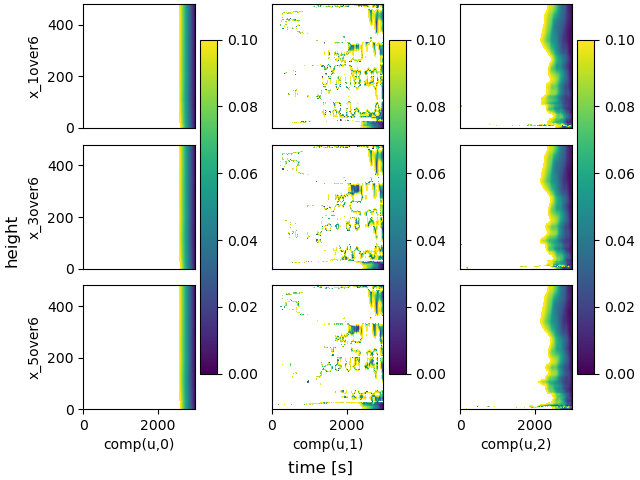

In [6]:
plot_params = {
    'plot_levels' : {
        'comp(u,0)' : np.linspace(0,.1,200),
        'comp(u,1)' : np.linspace(0,.1,200),
        'comp(u,2)' : np.linspace(0,.1,200)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height',
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    # names = ['x_1over6','x_3over6'], 
    steps = probes.probe_steps[:-10],
#     quants = ['comp(u,0)', 'comp(u,1)'],
    parrallel = True,
    processing = [probePost.mean_convergence],
    plot_params = plot_params
    )

In [9]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_convergence')

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 6 seconds
memorizing data took 1 seconds


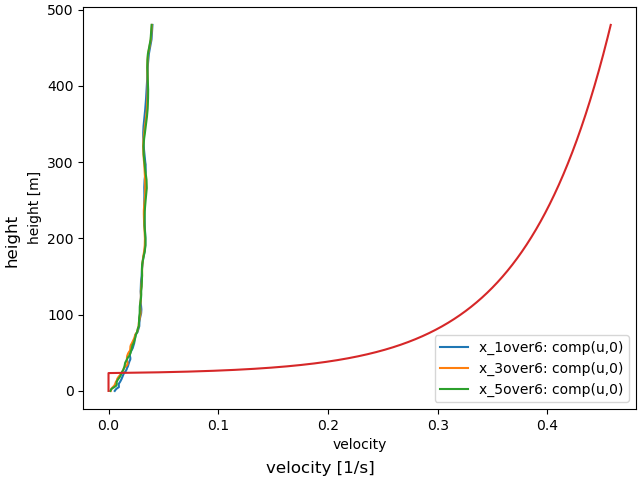

In [6]:
probes.profile_plots(
    # names = ['x_3over6'],
    steps = probes.probe_steps[-1000:-10],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'velocity [1/s]',
        'ylabel' : 'height'
        },
    parrallel=True
    )

physics_setup.plot_log_wind()